In [1]:
pip install vowpalwabbit

     |████████████████████████████████| 2.2 MB 18.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt

In [3]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

In [4]:
def get_cost(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [5]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [6]:
context = {"user":"Tom","time_of_day":"morning"}
actions = ["politics", "sports", "music", "food"]

print(to_vw_example_format(context,actions))

shared |User user=Tom time_of_day=morning
|Action article=politics 
|Action article=sports 
|Action article=music 
|Action article=food 


In [7]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [8]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [9]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

In [10]:
def run_simulation(vw, num_iterations, users, times_of_day, actions, cost_function, do_learn = True):
    cost_sum = 0.
    ctr = []

    for i in range(1, num_iterations+1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {'user': user, 'time_of_day': time_of_day}
        action, prob = get_action(vw, context, actions)

        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
            # 6. Learn
            vw.learn(vw_format)
            # 7. Let VW know you're done with these objects
            vw.finish_example(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/i)

    return ctr

In [11]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

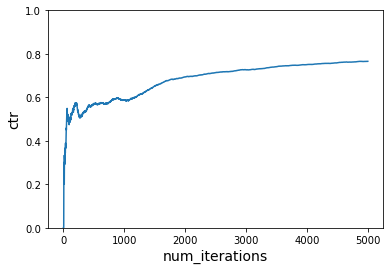

In [12]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)

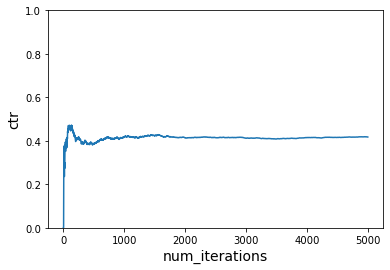

In [13]:
# Instantiate learner in VW but without -q
vw = pyvw.vw("--cb_explore_adf --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)

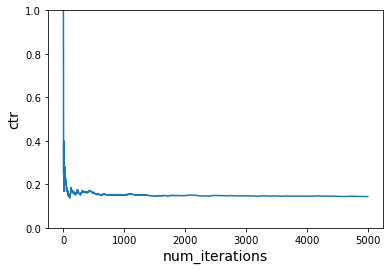

In [14]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost, do_learn=False)

plot_ctr(num_iterations, ctr)

In [15]:
def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [16]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

In [19]:
# Modify the second scenario in the following ways:

# Add multiple changes to the reward distribution over time
# Introduce varying noise in the reward distribution
# Run this new simulator with different exploration algorithms and vizualize and compare their performance.

# Submit a Jupyter notebook showcasing the above in a GitHub repo for your application

# SECOND SCENARIO

In [23]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

In [24]:
def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [25]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

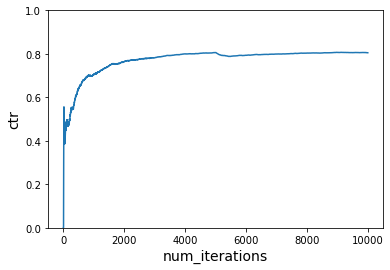

In [26]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

In [ ]:
# changing reward to positive reward and disliked as negative

In [27]:
# VW tries to minimize loss/cost, therefore we will pass cost as -0.75 reward and disliked as 0.0
USER_LIKED_ARTICLE = -0.75
USER_DISLIKED_ARTICLE = 0.0

In [33]:
def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [34]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

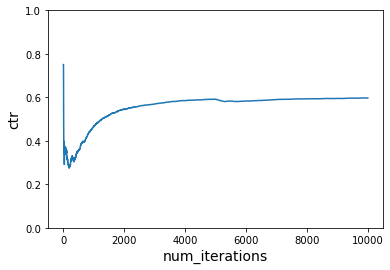

In [30]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

In [32]:
USER_LIKED_ARTICLE = -0.5
USER_DISLIKED_ARTICLE = 0.0

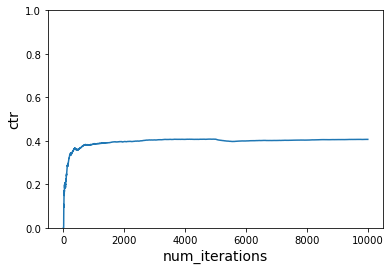

In [35]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

In [ ]:
# Playing with epsilon, which seems to add noise

# SECOND SCENARIO

In [37]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

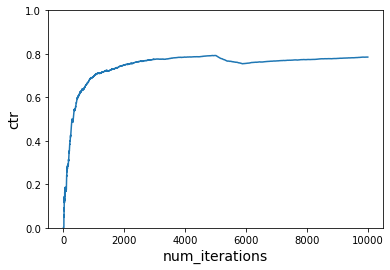

In [38]:
# no noise:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

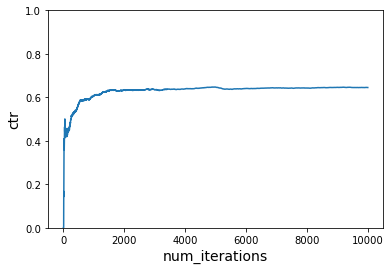

In [39]:
# adding noise modify epsilon:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.4")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

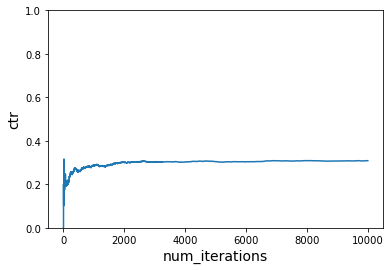

In [40]:
# adding noise:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.8")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

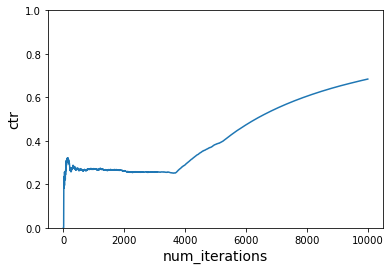

In [41]:
# adding noise (small epsilon):
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.001")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

In [ ]:
# let's look up some different sploration algorithms!

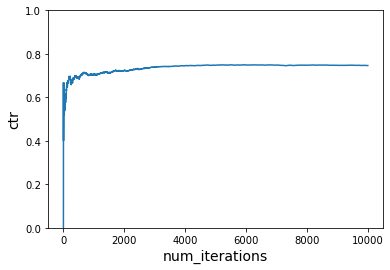

In [42]:
# adding noise (small epsilon):
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
pyvw.vw("-b 2 --loss_function poisson -l 0.1 --holdout_off -f vw.poisson.model --readable_model vw.readable.poisson.model")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

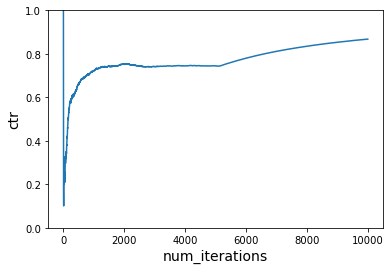

In [47]:
# Bagging

# adding noise (small epsilon):
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf --bag 5 -q UA --quiet --epsilon 0.001")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

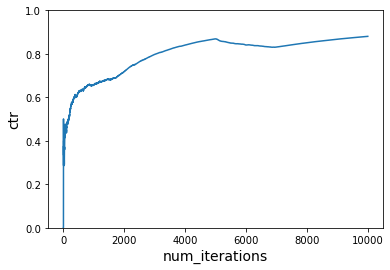

In [48]:
# Sploring softmax
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf --softmax --lambda 10 -q UA --quiet --epsilon 0.001")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

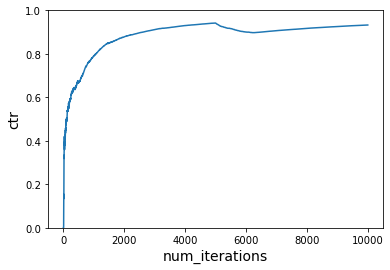

In [49]:
# Sploring softmax with bigger epsilon
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf --softmax --lambda 10 -q UA --quiet --epsilon 0.01")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)